In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

In [2]:
sns.set(style = "whitegrid", palette = "deep", font_scale = 1.1)

In [3]:
df = pd.read_csv("sf_sold_houses_raw.csv", parse_dates = ["sold_date"], infer_datetime_format = True)

# Summary statistics

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1899 entries, 0 to 1898
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   sold_date               1899 non-null   datetime64[ns]
 1   bedrooms                1899 non-null   int64         
 2   bathrooms               1899 non-null   int64         
 3   build_year              1899 non-null   int64         
 4   build_type              1899 non-null   object        
 5   area                    1899 non-null   int64         
 6   lot_area                1899 non-null   int64         
 7   parking_spots           1899 non-null   int64         
 8   homeowners_association  1899 non-null   bool          
 9   zip_code                1899 non-null   int64         
 10  nearby_elem_school      1899 non-null   float64       
 11  nearby_middle_school    1899 non-null   float64       
 12  nearby_high_school      1899 non-null   float64 

In [5]:
df.describe()

,bedrooms,bathrooms,build_year,area,lot_area,parking_spots,zip_code,nearby_elem_school,nearby_middle_school,nearby_high_school,nh_median_price,nh_days_on_market,nh_price_per_sqft,price
count,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1.899000e+03,1899.000000,1899.000000,1.899000e+03
mean,2.325961,1.751975,1953.365982,1382.619273,19318.837283,1.010005,94116.411269,0.549394,1.455924,0.591101,1.518088e+06,45.880463,993.733544,1.506680e+06
std,1.111116,0.812890,39.732341,1074.351553,41172.434472,0.690447,10.682895,0.447441,1.056572,0.303440,4.483653e+05,16.930121,182.132557,7.757007e+05
min,0.000000,0.000000,1874.000000,0.000000,4.000000,0.000000,94102.000000,0.000000,0.000000,0.000000,4.400000e+05,21.000000,616.000000,2.275720e+05
25%,2.000000,1.000000,1921.000000,908.000000,2498.500000,1.000000,94109.000000,0.200000,0.600000,0.400000,1.255000e+06,35.000000,881.000000,9.999975e+05
50%,2.000000,2.000000,1946.000000,1209.000000,3156.000000,1.000000,94114.000000,0.400000,1.100000,0.600000,1.400000e+06,42.000000,967.000000,1.375000e+06
75%,3.000000,2.000000,1993.000000,1559.000000,14252.000000,1.000000,94122.000000,0.700000,2.200000,0.800000,1.775000e+06,55.000000,1159.000000,1.800000e+06
max,9.000000,7.000000,2021.000000,26886.000000,325629.000000,6.000000,94158.000000,2.100000,4.500000,1.600000,3.328800e+06,114.000000,1420.000000,8.000000e+06


# Price distribution

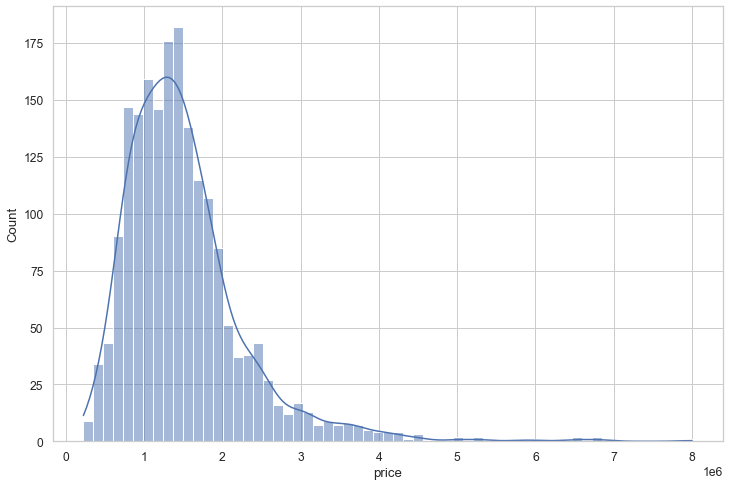

In [6]:
plt.figure(figsize = (12, 8))
sns.histplot(df["price"], kde = True)
plt.show()

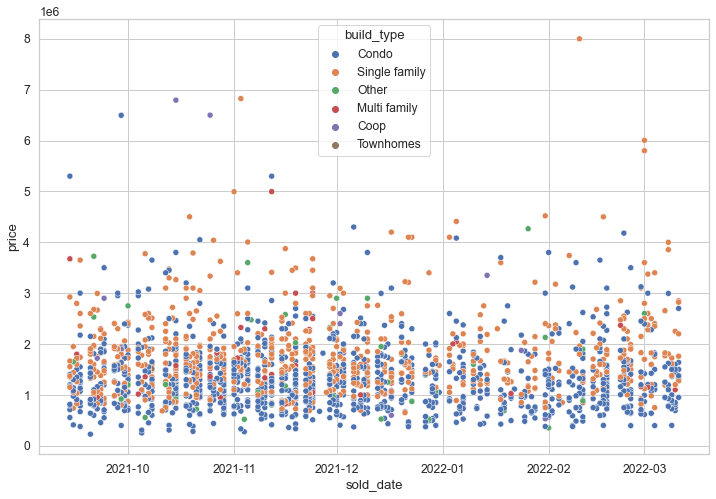

In [7]:
plt.figure(figsize = (12, 8))
sns.scatterplot(x = df["sold_date"], y = df["price"], hue = df["build_type"])
plt.show()

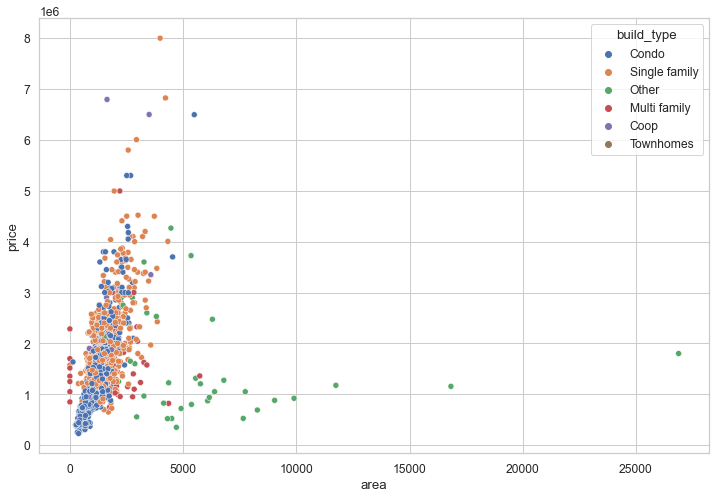

In [8]:
plt.figure(figsize = (12, 8))
sns.scatterplot(x = df["area"], y = df["price"], hue = df["build_type"])
plt.show()

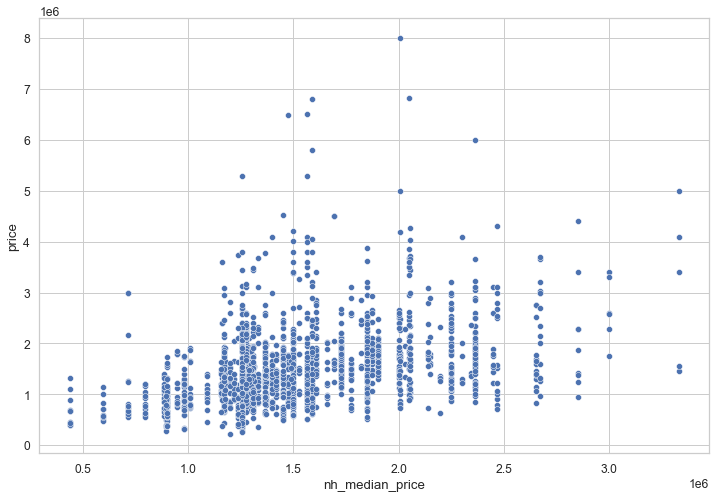

In [9]:
plt.figure(figsize = (12, 8))
sns.scatterplot(x = df["nh_median_price"], y = df["price"])
plt.show()

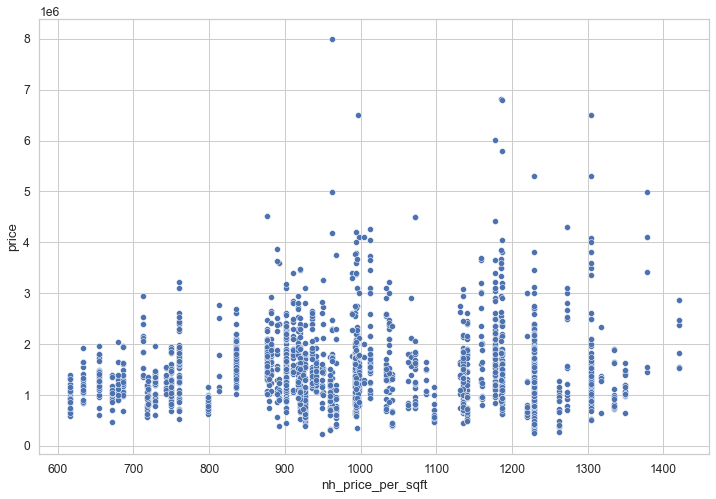

In [10]:
plt.figure(figsize = (12, 8))
sns.scatterplot(x = df["nh_price_per_sqft"], y = df["price"])
plt.show()

Overall distribution of house prices seems approximately normal except for several expensive outliers. Several properties of type "Other" appear to have unusually high prices and/or areas. 

# Property types

In [11]:
df["build_type"].value_counts()

Condo            1077
Single family     720
Other              47
Multi family       40
Coop               14
Townhomes           1
Name: build_type, dtype: int64

Properties of types other then "Condo" and "Single family" constitute only around 0.5% of the dataset. It may be reasonable to remove these observations before building the model since their behavior is very different from the rest of the properties.

In [12]:
df_clean = df[df["build_type"].isin(["Condo", "Single family"])]

# ZIP codes

In [13]:
df_clean["zip_code"].value_counts()

94107    155
94110    149
94112    147
94109    138
94116    110
94131    107
94114     87
94105     79
94117     76
94115     75
94122     72
94102     70
94134     66
94118     63
94103     58
94127     54
94121     47
94123     47
94124     46
94132     41
94158     37
94133     37
94111     18
94108     17
94104      1
Name: zip_code, dtype: int64

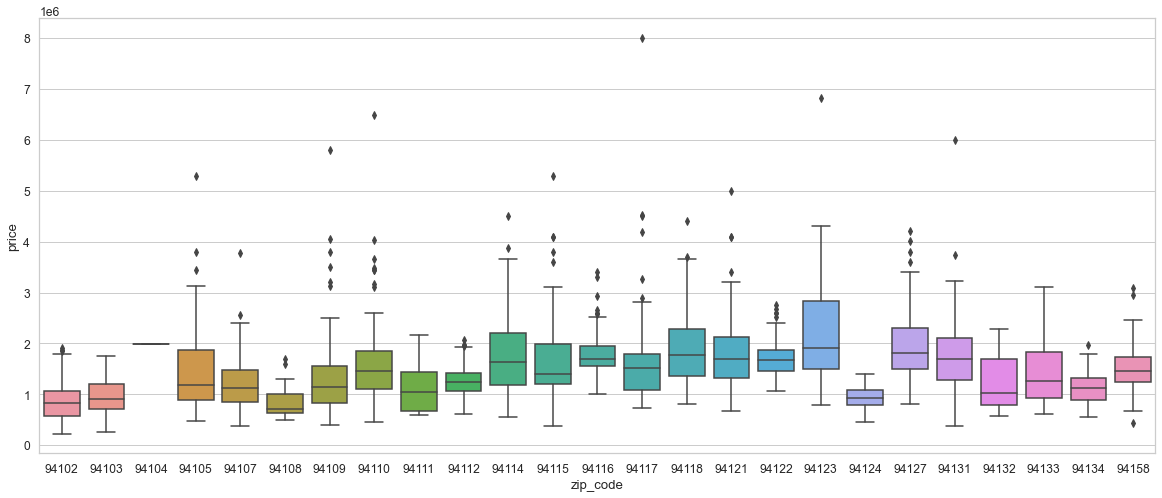

In [14]:
plt.figure(figsize = (20, 8))
sns.boxplot(x = df_clean["zip_code"], y = df_clean["price"])
plt.show()

ZIP codes might contains valuable information, however most of them have too few observations to draw meaningful conclusions. Hence, all ZIP codes with less than 80 house sales are set to "Other".

In [15]:
df_clean.loc[~df_clean["zip_code"].isin([94110, 94107, 94109, 94112, 94131, 94116, 94114, 94117, 94105, 94115]), "zip_code"] = "Other"

# Brokers

In [16]:
df_clean["selling_broker"].value_counts().head(10)

COMPASS                                                     596
Corcoran Global Living                                      114
Sotheby's International Realty - San Francisco Brokerage     99
Coldwell Banker Realty                                       88
Vanguard Properties, Inc.                                    55
Vanguard Properties                                          46
Keller Williams San Francisco                                40
BarbCo Real Estate Group (Barbagelata)                       34
Compass                                                      31
Sotheby's International Realty                               31
Name: selling_broker, dtype: int64

In [17]:
df_clean["buying_broker"].value_counts().head(10)

COMPASS                                                     533
Corcoran Global Living                                       96
Compass                                                      76
Coldwell Banker Realty                                       68
Sotheby's International Realty - San Francisco Brokerage     60
Vanguard Properties, Inc.                                    50
Vanguard Properties                                          49
Keller Williams San Francisco                                39
UNKNOWN NAME                                                 36
CENTURY 21 Real Estate Alliance                              35
Name: buying_broker, dtype: int64

Several big players appear to be responsible for most transactions. At the same time, there are discrepancies in the ways the firm names are written. Therefore, deals of each of the leading brokerage firms are aggregated together under the corresponding name while the rest of the values will be referred to as "Other". 

In [18]:
def substitute_column_value(df, column, old_value, new_value):
    df.loc[df[column] == old_value, column] = new_value
    return df

In [19]:
for broker in ["selling_broker", "buying_broker"]:
    df_clean = substitute_column_value(df_clean, broker, "COMPASS", "Compass")
    df_clean = substitute_column_value(df_clean, broker, "Sotheby's International Realty - San Francisco Brokerage", "Sotheby's International Realty")
    df_clean = substitute_column_value(df_clean, broker, "Vanguard Properties, Inc.", "Vanguard Properties")

In [20]:
df_clean["selling_broker"].value_counts().head(10)

Compass                                    627
Sotheby's International Realty             130
Corcoran Global Living                     114
Vanguard Properties                        101
Coldwell Banker Realty                      88
Keller Williams San Francisco               40
BarbCo Real Estate Group (Barbagelata)      34
Berkshire Hathaway-Franciscan               23
Skybox Realty                               22
Park North Real Estate                      19
Name: selling_broker, dtype: int64

In [21]:
df_clean["buying_broker"].value_counts().head(10)

Compass                            609
Vanguard Properties                 99
Corcoran Global Living              96
Sotheby's International Realty      84
Coldwell Banker Realty              68
Keller Williams San Francisco       39
UNKNOWN NAME                        36
CENTURY 21 Real Estate Alliance     35
eXp Realty of California Inc.       29
Intero Real Estate Services         28
Name: buying_broker, dtype: int64

All brokers out of top-5 by the number of deals are set to "Other"

In [22]:
top_brokers = ["Compass", "Vanguard Properties", "Corcoran Global Living", "Sotheby's International Realty", "Coldwell Banker Realty"]
for broker in ["selling_broker", "buying_broker"]:
    df_clean.loc[~df_clean[broker].isin(top_brokers), broker] = "Other"

In [23]:
df_clean["selling_broker"].value_counts()

Other                             737
Compass                           627
Sotheby's International Realty    130
Corcoran Global Living            114
Vanguard Properties               101
Coldwell Banker Realty             88
Name: selling_broker, dtype: int64

In [24]:
df_clean["buying_broker"].value_counts()

Other                             841
Compass                           609
Vanguard Properties                99
Corcoran Global Living             96
Sotheby's International Realty     84
Coldwell Banker Realty             68
Name: buying_broker, dtype: int64

# Homeowners association

In [25]:
df_clean["homeowners_association"] = np.where(df_clean["homeowners_association"] == True, 1, 0)

In [26]:
df_clean["homeowners_association"].value_counts()

1    1093
0     704
Name: homeowners_association, dtype: int64

# Distance to schools and price

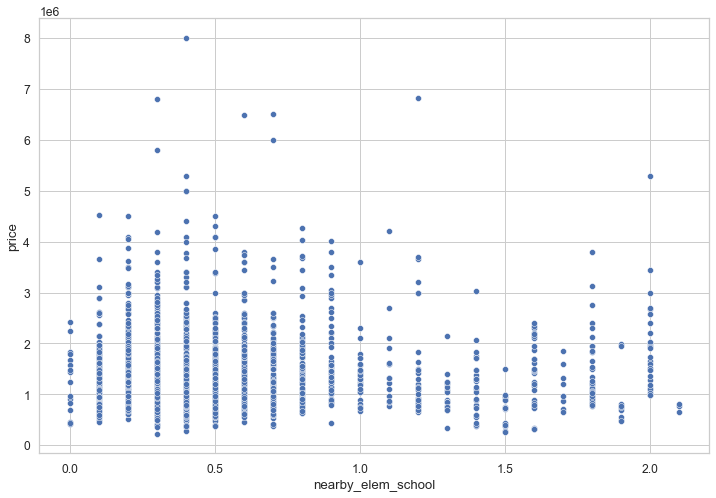

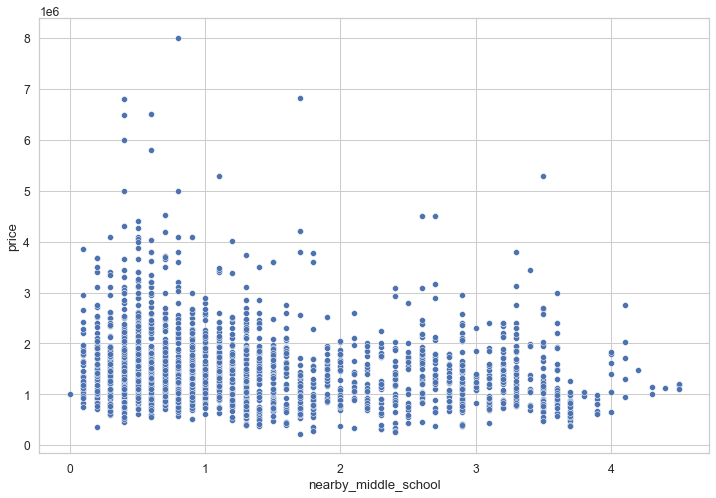

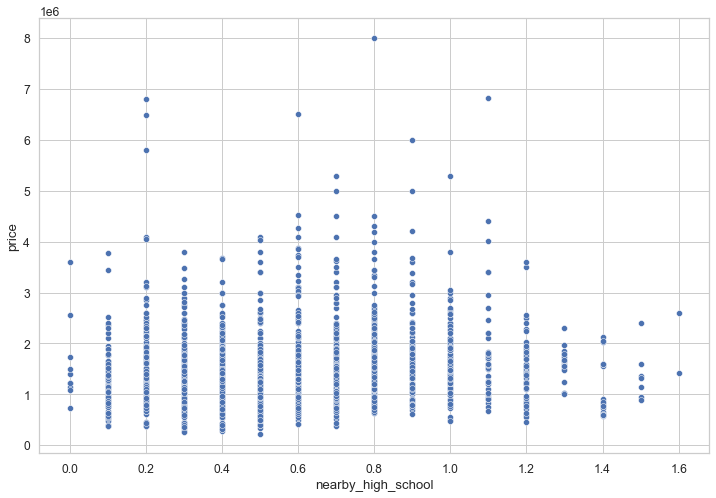

In [27]:
for school in ["elem", "middle", "high"]:
    plt.figure(figsize = (12, 8))
    sns.scatterplot(x = df["nearby_{}_school".format(school)], y = df["price"])
    plt.show()

# Sale date -> days since sale

In [28]:
max_date = df_clean["sold_date"].max()
df_clean["days_since_sale"] = (max_date - df_clean["sold_date"]) / np.timedelta64(1, 'D')
df_clean = df_clean.drop(columns = ["sold_date"])

# Saving cleaned dataframe

In [29]:
df_clean.to_csv("sf_sold_houses_clean.csv", index = False)